In [29]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

In [30]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def plotlabel(xvar, yvar, label):
        ax.text(xvar, yvar, label)

### Generate simple data set

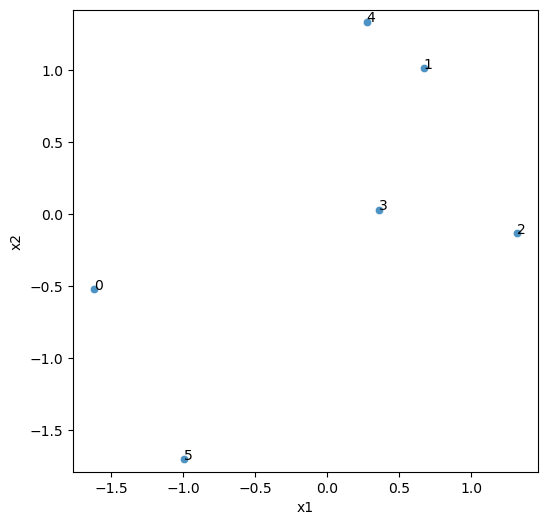

In [60]:
X = np.random.uniform(size= (6, 2))

X = StandardScaler().fit_transform(X)

df = pd.DataFrame(X, columns= ['x1', 'x2'])
df.reset_index(inplace= True)
df.rename(columns= {'index':'idx'}, inplace= True)

plt.figure(figsize= (6, 6))
ax = sns.scatterplot(x = df.x1, y = df.x2, alpha = 0.8)
df.apply(lambda x: plotlabel(x.x1,  x.x2, int(x.idx)), axis=1)
plt.axis('equal')
plt.show()

### Cluster data and display dendrogram

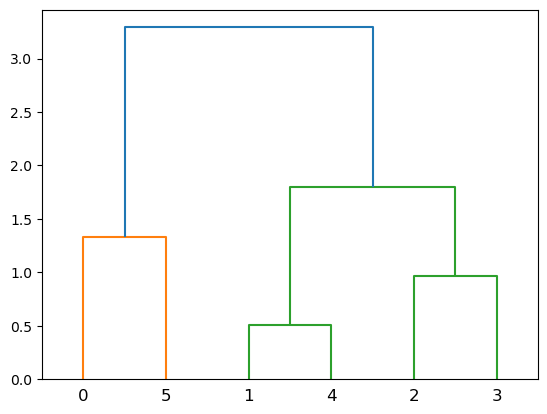

In [61]:
agglo = AgglomerativeClustering(n_clusters= 1, compute_distances= True, linkage= 'complete').fit(df[['x1', 'x2']])

plot_dendrogram(agglo)

### Calculate all-to-all distance matrix

In [62]:
dist_matrx = pd.DataFrame(cdist(XA= df[['x1', 'x2']], XB= df[['x1', 'x2']])).stack().reset_index()
dist_matrx.columns = ['idx1', 'idx2', 'dist']
dist_matrx = dist_matrx[dist_matrx.idx2 > dist_matrx.idx1]
dist_matrx.sort_values(by= 'dist', ascending= True, inplace= True)
dist_matrx

,idx1,idx2,dist
10,1,4,0.510126
15,2,3,0.968280
9,1,3,1.031128
22,3,4,1.309673
8,1,2,1.315643
5,0,5,1.335573
16,2,4,1.800451
3,0,3,2.055613
23,3,5,2.200868
4,0,4,2.651036


### Reduce matrix with Complete Linkage

In [63]:
temp_matrx = dist_matrx.copy()
merged = np.empty([0, 3])

while temp_matrx.shape[0] > 0:

    
    merged = np.vstack([merged, temp_matrx.iloc[0].to_numpy()])
    new_cluster_idx = np.max([temp_matrx.idx1.max(), temp_matrx.idx2.max()]) + 1
    to_merge = temp_matrx.iloc[0]

    print(temp_matrx)
    print(f'Merging index {int(to_merge[0])} and index {int(to_merge[1])}')
    print(f'Replacing indices {int(to_merge[0])} and {int(to_merge[1])} with {new_cluster_idx}')
    
    temp_matrx = temp_matrx[1:]
    temp_matrx.replace({to_merge.idx1:new_cluster_idx, to_merge.idx2: new_cluster_idx}, inplace= True)
    print(temp_matrx)
    
    temp_matrx['idx'] = temp_matrx[['idx1', 'idx2']].values.tolist()
    temp_matrx['idx'] = temp_matrx.idx.apply(lambda x: sorted(x))
    
    temp_matrx.drop_duplicates(subset= ['idx'], keep= 'last', inplace= True)
    print('Keep maximum distance for duplicate index pairs')
    print('Leaves the following distance matrix...')
    print()
    temp_matrx.drop(columns= ['idx'], inplace= True)

    idx1  idx2      dist
10     1     4  0.510126
15     2     3  0.968280
9      1     3  1.031128
22     3     4  1.309673
8      1     2  1.315643
5      0     5  1.335573
16     2     4  1.800451
3      0     3  2.055613
23     3     5  2.200868
4      0     4  2.651036
1      0     1  2.754580
17     2     5  2.796199
2      0     2  2.961216
11     1     5  3.185956
29     4     5  3.293103
Merging index 1 and index 4
Replacing indices 1 and 4 with 6
    idx1  idx2      dist
15     2     3  0.968280
9      6     3  1.031128
22     3     6  1.309673
8      6     2  1.315643
5      0     5  1.335573
16     2     6  1.800451
3      0     3  2.055613
23     3     5  2.200868
4      0     6  2.651036
1      0     6  2.754580
17     2     5  2.796199
2      0     2  2.961216
11     6     5  3.185956
29     6     5  3.293103
Keep maximum distance for duplicate index pairs
Leaves the following distance matrix...

    idx1  idx2      dist
15     2     3  0.968280
22     3     6  1.309673


In [64]:
merged

array([[1.        , 4.        , 0.51012649],
       [2.        , 3.        , 0.96828037],
       [0.        , 5.        , 1.33557251],
       [7.        , 6.        , 1.8004512 ],
       [9.        , 8.        , 3.29310324]])

In [57]:
agglo.distances_

array([1.01264615, 1.45383691, 1.49701554, 2.86565043, 3.34004988])

### More complicated data

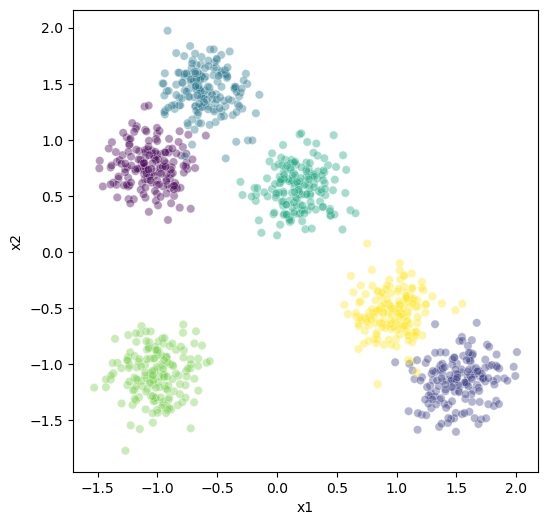

In [65]:
X, y = make_blobs(n_samples= 1000, centers= 6, n_features= 2, random_state= 4321)
X = StandardScaler().fit_transform(X)
df = pd.DataFrame(X, columns= ['x1', 'x2'])
df['label'] = y


plt.figure(figsize= (6, 6))
sns.scatterplot(x= df.x1, y= df.x2, c= df.label, alpha= 0.4)
plt.show()

In [66]:
agglo = AgglomerativeClustering(n_clusters= 1, compute_distances= True, linkage= 'complete').fit(df[['x1', 'x2']])

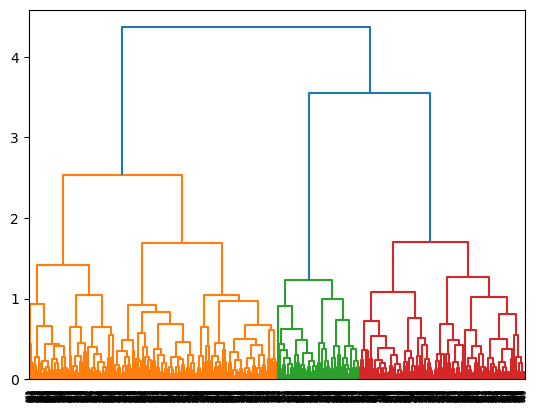

In [67]:
plot_dendrogram(agglo)

### Use silhouette analysis to estimate k

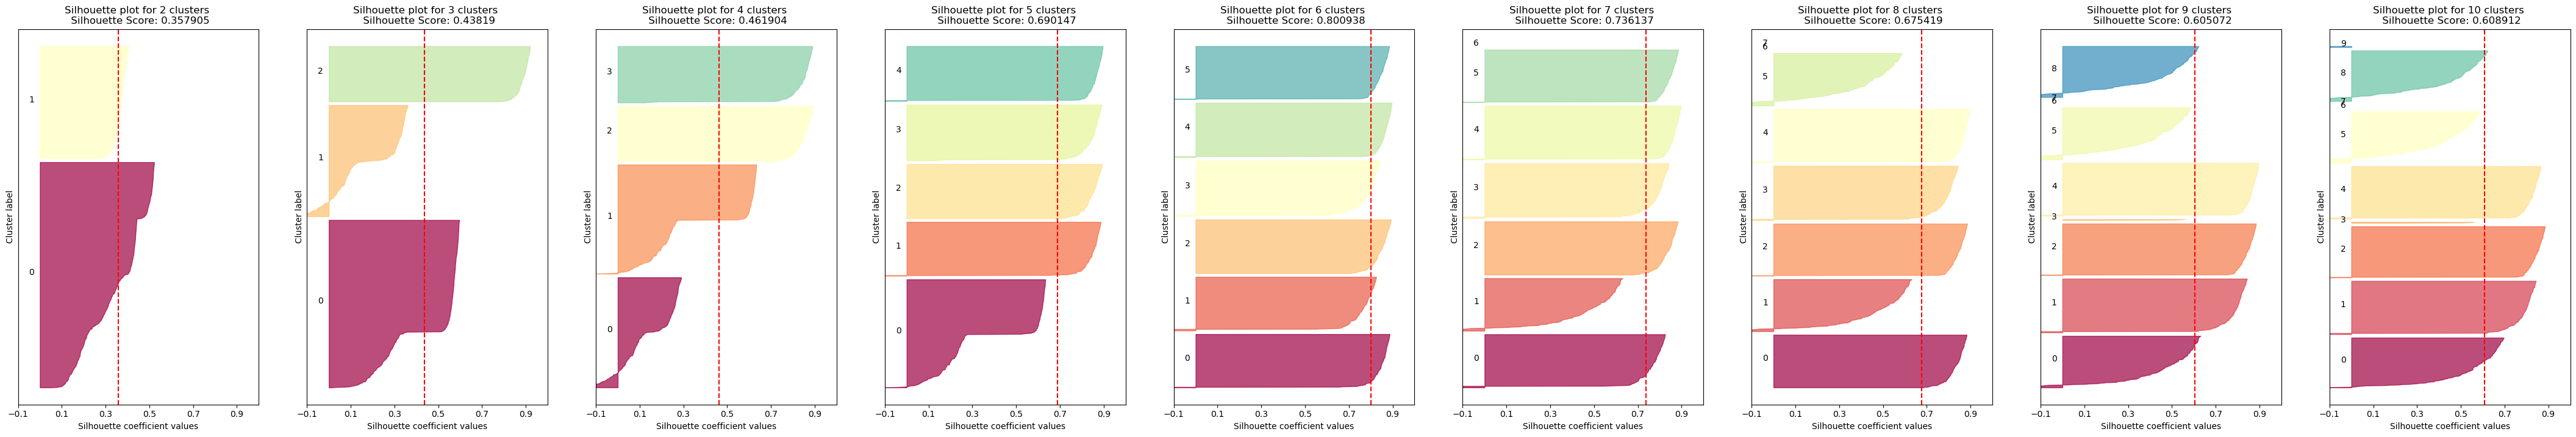

In [72]:
silhouette_value_by_k = np.empty((0, 2))

k_values = np.arange(2, 11, 1)
plt.figure(figsize=(len(k_values) * 6, 8))

for i, k in enumerate(k_values):
    aggl = AgglomerativeClustering(n_clusters= k, compute_distances= True, linkage= 'average').fit(df[['x1', 'x2']])
    labels = aggl.labels_
    
    silhouette_values = silhouette_samples(df, labels)
    
    silhouette_value_by_k = np.vstack([silhouette_value_by_k, [k, silhouette_values.mean()]])
    
    plt.subplot(1, len(k_values), i + 1)
    y_lower= 10
    for j in range(k):
        ith_cluster_silhouette_values = silhouette_values[labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        
        color = plt.colormaps.get_cmap("Spectral")(float(j) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title(f"Silhouette plot for {k} clusters \n Silhouette Score: {round(silhouette_values.mean(), 6)}")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x= silhouette_values.mean(), color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

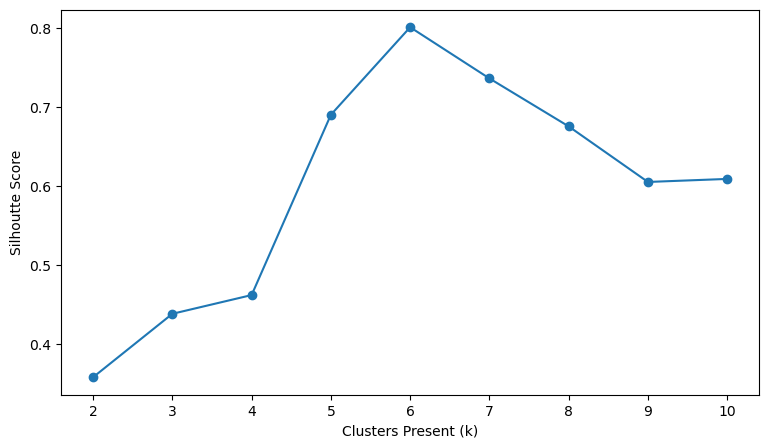

In [73]:
plt.figure(figsize= (9, 5))
plt.scatter(x= silhouette_value_by_k[:, 0], y= silhouette_value_by_k[:, 1])
plt.plot(silhouette_value_by_k[:, 0], silhouette_value_by_k[:, 1])
plt.ylabel('Silhoutte Score')
plt.xlabel('Clusters Present (k)')
plt.show()